In [17]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torchtnt.utils.data import CudaDataPrefetcher
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

import json
from torch import nn

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from numbers import Number
from math import floor
import time
from torch.amp import autocast, GradScaler
import gc


In [18]:
# Import cifar-10 dataset


cifar_10_deletables = []
cifar_100_deletables = []
models = []
data_path = './data'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
def gen_data_loader(
    data,
    batch_size = 8192,
    workers = 6,
    cpu_prefetch = 10,
    gpu_prefetch = 10,
):
    start = time.perf_counter()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    gc.collect()

    print('Begin init data loader')
    loader = DataLoader(
        data,
        batch_size=batch_size,
        num_workers=workers,
        prefetch_factor=cpu_prefetch,
        pin_memory=True,
    )
    
    X_batch = next(iter(loader))[0]
    
    print(f"Batch Size: {X_batch.element_size() * X_batch.nelement() / 1024**2} MiB")
    print(f"Data Loader init time: {time.perf_counter() - start:2f} s")
    print("Begin init fetcher")
    fetcher = CudaDataPrefetcher(
        data_iterable=loader,
        num_prefetch_batches=gpu_prefetch,
        device=torch.device('cuda')
    )
    print(f"Fetcher init time: {time.perf_counter() - start:2f} s")
    return fetcher

def get_cifar(
    is_cifar_10,
    recompute=False,
    redownload=False,
    data_path='./data'
):
    title = 'cifar10' if is_cifar_10 else 'cifar100'
    cifar = datasets.CIFAR10 if is_cifar_10 else datasets.CIFAR100 
    
     
    if recompute:
        pre_cifar = cifar(data_path, train=True, download=redownload, transform=transforms.ToTensor())
        train_imgs = torch.stack([img for img, _ in pre_cifar], dim=3)
        mean = train_imgs.view(3, -1).mean(dim=1)
        std = train_imgs.view(3, -1).std(dim=1)
        torch.save(mean, f'data/mean_{title}.pt')
        torch.save(std, 'data/std_{title}.pt')
        del pre_cifar, train_imgs
    else:
        mean = torch.load(f'data/mean_{title}.pt')
        std = torch.load(f'data/std_{title}.pt')
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    
    cifar_train = cifar(data_path, train=True, download=redownload, transform=transform) 
    cifar_val = cifar(data_path, train=False, download=redownload, transform=transform)
    return cifar_train, cifar_val

def get_val_tensor(data):
    val_x = torch.empty(len(data), *data[0][0].shape, device='cuda')
    val_y = torch.empty(len(data), device='cuda', dtype=torch.long)
    
    for idx, (x, y) in enumerate(data):
        val_x[idx] = x.to('cuda')
        val_y[idx] = y
    return val_x, val_y
def delete_deletables(deletables):
    for d in deletables:
        del d
    deletables.clear()
    gc.collect()

In [ ]:
# CIFAR10
batch_size_10 = 8192
workers_10 = 6
cpu_prefetch_10 = 10
gpu_prefetch_10 = 10



# Get cifar10
cifar10_train, cifar10_val = get_cifar(is_cifar_10 = True, recompute=True, redownload=False)
cifar_10_train_loader = gen_data_loader(data = cifar10_train, batch_size=batch_size_10, workers=workers_10, cpu_prefetch=cpu_prefetch_10, gpu_prefetch=gpu_prefetch_10)
cifar_10_val_x, cifar_10_val_y = get_val_tensor(data = cifar10_val)
cifar_10_deletables.append(cifar10_train, cifar10_val, cifar_10_train_loader, cifar_10_val_x, cifar_10_val_y)


Begin init data loader
Batch Size: 96.0 MiB
Data Loader init time: 4.444109 s
Begin init fetcher
Fetcher init time: 4.622176 s


In [ ]:

# Get cifar100

batch_size_100 = 1024
workers_100 = 6
cpu_prefetch_100 = 10
gpu_prefetch_100 = 10


cifar100_train, cifar100_val = get_cifar(is_cifar_10 = False, recompute=True, redownload=False)
cifar_100_train_loader = gen_data_loader(data = cifar100_train, batch_size=batch_size_100, workers=workers_100, cpu_prefetch=cpu_prefetch_100, gpu_prefetch=gpu_prefetch_100)
cifar_100_val_x, cifar_100_val_y = get_val_tensor(data = cifar100_val)
cifar_100_deletables.append(cifar100_train, cifar100_val, cifar_100_train_loader, cifar_100_val_x, cifar_100_val_y)


In [5]:


class Classifier(nn.Module):
    @classmethod
    def compare_results(cls, results1, results2):
        print('Comparing results:')
        
        for key, value in results1.items():
            if isinstance(value, Number): print(f"{key} : {100*(value - results2[key]) / value:2f} %") 
        
    def __init__(self):
        super().__init__()
    
    def get_results(self, Y_val=None, Y_pred=None):
        if Y_val is None:
            Y_val = self.last_val
        if Y_pred is None:
            Y_pred = self.last_pred
            
        if isinstance(Y_val, torch.Tensor):
            Y_val = Y_val.cpu().detach().numpy()
        if isinstance(Y_pred, torch.Tensor):
            Y_pred = Y_pred.cpu().detach().numpy()
        results = {
            'accuracy': accuracy_score(Y_val, Y_pred),
            'precision': precision_score(Y_val, Y_pred, average='weighted'),
            'recall': recall_score(Y_val, Y_pred, average='weighted'),
            'f1': f1_score(Y_val, Y_pred, average='weighted'),
            'confusion_matrix': confusion_matrix(Y_val, Y_pred),
            'classification_report': classification_report(Y_val, Y_pred)
        }
        self.last_results = results
        return results
    def print_results(self, results=None):
        if results is None:
            try: 
                results = self.last_results
            except:
                results = self.get_results()
        for key, value in results.items():
            if key in ['confusion_matrix', 'classification_report']:
                print(f'{key.capitalize()}:\n{value}')
            else:
                print(f'{key.capitalize()}: {value}')
    def plot_training(self, title: str):
        loss_hist = self.train_loss_hist.cpu().detach().numpy()
        accuracy_hist = self.train_accuracy_hist.cpu().detach().numpy()
        validation_accuracy_hist = self.validation_accuracy_hist.cpu().detach().numpy()
        
        fig, ax = plt.subplots(1,2, sharex=True)
        fig.suptitle(title)
        ax[0].set_title('Training Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].plot(loss_hist, label='Training Loss')
        
        
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].plot(accuracy_hist, label='Training Accuracy')
        ax[1].plot(validation_accuracy_hist, label='Validation Accuracy')
        
        plt.legend()
        plt.show()
    def plot_confusion_matrix(self, title):
        if not hasattr(self, 'last_results'):
            self.get_results()
        cm = self.last_results['confusion_matrix']
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        disp.ax_.set_title(title)
    def forward(self, x):
        return self.sequential(x)
    def predict(self, x):
        with torch.no_grad():
            return self.forward(x).argmax(dim=1)
    def train_model_old(
        self,
        epochs,
        train_loader,
        test_loader,
        train_len,
        test_len,
        test_size,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD,
        optimizer_args = [],
        optimizer_kwargs = {},
        print_epoch=10,
        header_epoch = 15,
        sched_factor = 0.1,
        sched_patience = 5
    ):  
        
        scaler = GradScaler("cuda")
        optimizer = optimizer(self.parameters(), *optimizer_args, **optimizer_kwargs)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=sched_patience, factor=sched_factor)
        training_time = 0
        train_hist = torch.zeros(epochs, device=device)
        test_hist = torch.zeros(epochs, device=device)
        accuracy_hist = torch.zeros(epochs, device=device)
        
        cell_width = 20
        header_form_spec = f'^{cell_width}'
        
        epoch_inspection = {
            "Epoch": 0,
            "Epoch Time (s)": 0,
            "Training Loss": 0,
            "Test Loss ": 0,
            "Overfit (%)": 0,
            "Accuracy (%)": 0,
            "Δ Accuracy (%)": 0,
            "GPU Memory (GiB)": 0
        }

        header_string = "|"
        for key in epoch_inspection.keys():
            header_string += (f"{key:{header_form_spec}}|")
        
        divider_string = '-'*len(header_string)
        if print_epoch:
            print(f'Training {self.__class__.__name__}\n')
            print(divider_string)
        max_accuracy = torch.zeros(1, device=device)            
        for epoch in range(epochs):
            begin_epoch = time.time()
            self.train()
            
            start_time = time.time()
            train_loss = 0
            for X_batch, Y_batch in train_loader:
                #X_batch, Y_batch = X_batch.to(device, non_blocking=True), Y_batch.to(device, non_blocking=True)
                optimizer.zero_grad(set_to_none=True)
                with autocast("cuda"):
                    Y_pred = self.forward(X_batch)
                    loss = loss_fn(Y_pred, Y_batch)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                train_loss += loss
            training_time += time.time() - start_time
            
            train_loss = train_loss/train_len
            train_hist[epoch] = train_loss
            
            
            self.eval()
            with torch.no_grad():
                test_loss = torch.zeros(1, device=device)
                correct = torch.zeros(1, device=device)               
                
                for X_test_batch, Y_test_batch in test_loader:
                    #X_test_batch, Y_test_batch = X_test_batch.to(device, non_blocking=True), Y_test_batch.to(device, non_blocking=True)
                    
                    out = self.forward(X_test_batch)
                    test_loss += loss_fn(out, Y_test_batch)
                    correct += (out.argmax(dim=1) == Y_test_batch).sum()
                    
            test_loss = test_loss/test_len
            test_hist[epoch] = test_loss
            accuracy = correct/test_size
            accuracy_hist[epoch] = accuracy
            
            scheduler.step(accuracy)
            
            end_epoch = time.time()
            if print_epoch and (epoch % print_epoch == 0 or epoch == epochs - 1) :
                mem = (torch.cuda.memory_allocated() + torch.cuda.memory_reserved())/1024**3
                if header_epoch and epoch % header_epoch == 0:
                    print(header_string)
                    print(divider_string)
                epoch_duration = end_epoch - begin_epoch
                overfit = 100 * (test_loss - train_loss) / train_loss
                d_accuracy = torch.zeros(1) if max_accuracy == 0 else 100 * (accuracy - max_accuracy) / max_accuracy
                if accuracy > max_accuracy:
                    max_accuracy = accuracy
                
                epoch_inspection['Epoch'] = f'{epoch}'
                epoch_inspection['Epoch Time (s)'] = f'{epoch_duration:4f}'
                epoch_inspection['Training Loss'] = f'{train_loss.item():8f}'
                epoch_inspection['Test Loss '] = f'{test_loss.item():8f}'
                epoch_inspection['Overfit (%)'] = f'{overfit.item():4f}'
                epoch_inspection['Accuracy (%)'] = f'{accuracy.item()*100:4f}'
                epoch_inspection['Δ Accuracy (%)'] = f'{d_accuracy.item():4f}'
                epoch_inspection["GPU Memory (GiB)"] = f'{mem:2f}'
                for value in epoch_inspection.values():
                    print(f"|{value:^{cell_width}}", end='')
                print('|')
                print(divider_string)
            

        print(f'\nTraining Time: {training_time} seconds\n')
        
        self.train_hist = train_hist
        self.test_hist = test_hist
        self.accuracy_hist = accuracy_hist
    def train_model_old(
            self,
            epochs: int,
            train_loader: torch.utils.data.DataLoader,
            val_loader: torch.utils.data.DataLoader,
            alpha: float,
            loss_fn: nn.Module = nn.CrossEntropyLoss(),
            optimizer: nn.Module = torch.optim.SGD,
            print_epoch: int = 10,
            **optimizer_kwargs,
        ):
            self.train_loss_hist = torch.zeros(epochs).to(device)
            self.train_accuracy_hist = torch.zeros(epochs).to(device)
            self.validation_accuracy_hist = torch.zeros(epochs).to(device)
            
            scaler = GradScaler("cuda")
            optimizer = optimizer(self.parameters(), lr=alpha, **optimizer_kwargs)
            training_time = 0
            for epoch in range(epochs):
                self.train()
                
                start_time = time.time()
                train_loss = 0
                train_correct = torch.zeros(1).to(device)
                
                for X_batch, Y_batch in train_loader:
                    
                    X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                    optimizer.zero_grad()
                    with autocast("cuda"):
                        Y_pred = self.forward(X_batch)
                        loss = loss_fn(Y_pred, Y_batch)
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                    
                    train_loss += loss.item()
                    train_correct += (Y_pred.argmax(dim=1) == Y_batch).sum()
                training_time += time.time() - start_time
                
                self.train_accuracy_hist[epoch] = train_correct/len(train_loader.dataset)
                self.train_loss_hist[epoch] = train_loss/len(train_loader)
                
                val_correct = torch.zeros(1).to(device)
                self.eval()
                with torch.no_grad():
                    Y_pred_eval = torch.zeros(len(val_loader.dataset)).to(device)
                    
                    idx = 0
                    for X_val_batch, Y_val_batch in val_loader:
                        X_val_batch, Y_val_batch = X_val_batch.to(device), Y_val_batch.to(device)
                        batch_size = X_val_batch.size(0)
                        Y_pred = self.predict(X_val_batch)
                        Y_pred_eval[idx:idx + batch_size] = Y_pred
                        val_correct += (Y_pred == Y_val_batch).sum()
                        idx += batch_size
                        
                    self.validation_accuracy_hist[epoch] = val_correct/len(val_loader.dataset)
                epoch_time = time.time() - start_time
                
                        
                    
            
                if epoch % print_epoch == 0:
                    rem_time = (epochs - epoch)*epoch_time / 60
                    rem_time_str = f'{floor(rem_time):02}:{floor((rem_time - floor(rem_time))*60):02}'
                    print(f'Epoch {epoch}: Training Loss: {(train_loss/len(train_loader))}, Training Accuracy: {(train_correct/len(train_loader.dataset)).item()}, Validation Accuracy: {(val_correct/len(val_loader.dataset)).item()}, Estimated Time Remaining: {rem_time_str}')
            self.last_pred = torch.tensor(Y_pred_eval)
            self.last_val = torch.tensor(val_loader.dataset.targets)
            print(f'\nTraining Time: {training_time} seconds\n')
        
      

In [6]:
class ConvParams:
    def __init__(self, kernel, out_chan, stride=1, padding='same', in_chan=0,):
        self.kernel = kernel
        self.in_chan = in_chan
        self.out_chan = out_chan
        self.stride = stride
        self.padding = padding
    def __dict__(self):
        return {
            'kernel_size': self.kernel,
            'in_channels': self.in_chan,
            'out_channels': self.out_chan,
            'stride': self.stride,
            'padding': self.padding
        }
        
class AlexBlock(nn.Module):
    def __init__(
        self,
        params: ConvParams,
        pool_kernel = 3,
        pool_stride = 2,
    ):
        super().__init__()
        self.computation = nn.Sequential(
            # With batchnorm, bias is unnecessary
            nn.Conv2d(**params.__dict__(), bias=False),
            nn.ReLU(),
            nn.MaxPool2d(pool_kernel, pool_stride),
            nn.BatchNorm2d(params.out_chan),
        )
    def forward(self, x):
        return self.computation(x)
    

class AlexNet(Classifier):
        
    def __init__(
        self,
        in_chan,
        in_dim,
        num_classes,
        block_params: list = [],
        cnv_params =[],
        fc_layers = [],
        dropout = 0.5,
    ):
        super().__init__()
        self.cnv_layers = cnv_params
        self.fc_layers = fc_layers
        self.dropout = dropout
        self.input_dim = in_chan
        self.num_classes = num_classes
        
        block_params[0].in_chan = in_chan
        self.sequential = nn.Sequential(AlexBlock(block_params[0]))
        for i in range(1, len(block_params)):
            block_params[i].in_chan = block_params[i-1].out_chan
            self.sequential.add_module(module=AlexBlock(block_params[i]), name=f'block_{i}')
        for i in range(len(cnv_params)):
            if i == 0:
                cnv_params[i].in_chan = block_params[-1].out_chan
            else:
                cnv_params[i].in_chan = cnv_params[i-1].out_chan
            self.sequential.add_module(module=nn.Sequential(
                nn.Conv2d(**cnv_params[i].__dict__()).to(device),
                nn.ReLU()
            ), name = f"conv_{i}")
        
        self.sequential.add_module(module=nn.Sequential(
            nn.MaxPool2d(3, 2),
            nn.Dropout2d(dropout),
            nn.Flatten() 
        ), name = 'flatten')
        self.sequential = self.sequential.to(device)
        
        dummy_in = torch.randn(1, in_chan, *in_dim).to(device)  # Add batch dimension
        dummy_out = self.sequential(dummy_in)
        fc_in = dummy_out.shape[1]
        self.sequential.add_module(name='linear_0', module=nn.Linear(fc_in, fc_layers[0]))
        self.sequential.add_module(name='relu_0', module=nn.ReLU())
        self.sequential.add_module(name='dropout_0', module=nn.Dropout(dropout))
        for i in range(1, len(fc_layers)):
            self.sequential.add_module(name=f'linear_{i}', module=nn.Sequential(
                nn.Linear(fc_layers[i-1], fc_layers[i]),
                nn.ReLU()
            ))
        self.sequential.add_module(name = 'output', module=nn.Linear(fc_layers[-1], num_classes))        
        self.sequential = self.sequential.to(device)
        dummy_out = self.sequential(dummy_in)
        print(dummy_out.shape)
        


In [7]:
retrain_alex_100 = True
if retrain_alex_100:
    try:
        del alex_100
    except:
        pass
    torch.cuda.empty_cache()
    alex_100 = AlexNet(
        in_chan=3,
        in_dim=(32, 32),
        num_classes=100,
        block_params = [
            ConvParams(kernel=5, out_chan=32, stride=1, padding='same'),
            ConvParams(kernel=3, out_chan=64, stride=1, padding='same'),
        ],
        cnv_params = [
            ConvParams(kernel=3, out_chan=128, stride=1, padding='same'),
            ConvParams(kernel=3, out_chan=64, stride=1, padding='same'),
            ConvParams(kernel=5, out_chan=32, stride=1, padding='same'),
        ],
        fc_layers=[2048, 2048],
        dropout = 0.5
    ).to(device)

    alex_100.train_model_old(
        epochs=100,
        train_loader=cifar100_train_loader,
        val_loader=cifar100_val_loader,
        alpha=1e-3,
        optimizer=torch.optim.Adam,
        print_epoch=1,   
    )
    torch.save(alex_100, 'models/alex_100.pth')
else:
    alex_100 = torch.load('models/alex_100.pth')
    alex_100.to(device)

torch.Size([1, 100])
Epoch 0: Training Loss: 4.53416633605957, Training Accuracy: 0.01955999992787838, Validation Accuracy: 0.03680000081658363, Estimated Time Remaining: 22:00
Epoch 1: Training Loss: 4.26833895274571, Training Accuracy: 0.04016000032424927, Validation Accuracy: 0.05819999799132347, Estimated Time Remaining: 22:02
Epoch 2: Training Loss: 4.095596994672503, Training Accuracy: 0.06175999715924263, Validation Accuracy: 0.06589999794960022, Estimated Time Remaining: 17:20
Epoch 3: Training Loss: 3.96217519896371, Training Accuracy: 0.08283999562263489, Validation Accuracy: 0.09259999543428421, Estimated Time Remaining: 17:02
Epoch 4: Training Loss: 3.846242700304304, Training Accuracy: 0.09408000111579895, Validation Accuracy: 0.11189999431371689, Estimated Time Remaining: 16:12
Epoch 5: Training Loss: 3.7448179040636336, Training Accuracy: 0.10945999622344971, Validation Accuracy: 0.13580000400543213, Estimated Time Remaining: 16:45
Epoch 6: Training Loss: 3.6664742061070

KeyboardInterrupt: 

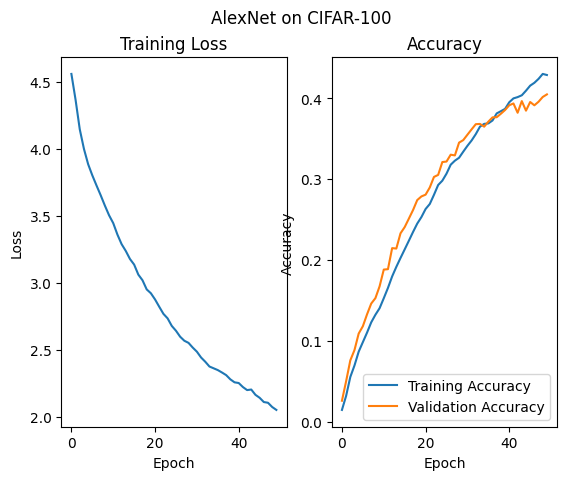

Error in callback <function _draw_all_if_interactive at 0x7f3f4b23a200> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

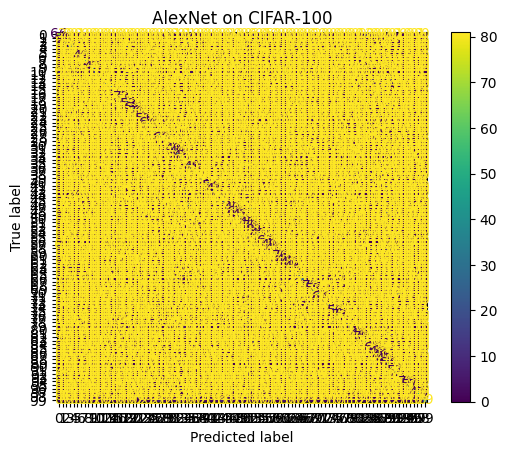

In [15]:
alex_100.plot_training('AlexNet on CIFAR-100')
#alex_100.plot_confusion_matrix('AlexNet on CIFAR-100')

In [ ]:
retrain_alex_nd_10 = False
if retrain_alex_nd_10:
    torch.cuda.empty_cache()
    alex_no_drop_10 = AlexNet(
        in_chan=3,
        in_dim=(32, 32),
        num_classes=10,
        block_params = [
            ConvParams(kernel=3, out_chan=16, stride=1, padding='same'),
            ConvParams(kernel=3, out_chan=32, stride=1, padding='same'),
        ],
        cnv_params = [
            ConvParams(kernel=3, out_chan=32, stride=1, padding='same'),
            ConvParams(kernel=3, out_chan=32, stride=1, padding='same'),
            ConvParams(kernel=3, out_chan=16, stride=1, padding='same'),
        ],
        fc_layers=[512, 256],
        dropout = 0
    ).to(device)

    alex_no_drop_10.train_model_old(
        epochs=50,
        train_loader=cifar_10_train_loader,
        val_loader=cifar_10_val_loader,
        alpha=1e-3,
        optimizer=torch.optim.Adam,
        print_epoch=1,
        
    )
    torch.save(alex_no_drop_10, 'models/alex_no_drop_10.pth')
else:
    alex_no_drop_10 = torch.load('models/alex_no_drop_10.pth')

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.AlexNet was not an allowed global by default. Please use `torch.serialization.add_safe_globals([AlexNet])` or the `torch.serialization.safe_globals([AlexNet])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

Accuracy: 0.6884
Precision: 0.687681356199599
Recall: 0.6884
F1: 0.6846494900375809
Confusion_matrix:
[[707  28  80  14  27  10   4  20  67  43]
 [  9 848   4   7   7   9   9   2  23  82]
 [ 71   3 538  52 113  84  93  23  11  12]
 [ 14  16  80 372  87 249 108  35  19  20]
 [ 19   3  56  33 689  47  75  65   8   5]
 [  7   6  52 106  53 673  34  61   3   5]
 [  4   4  49  42  51  19 820   5   4   2]
 [ 17   2  38  28  75 111  13 690   2  24]
 [ 73  67  17  16  11   9   9   3 755  40]
 [ 28  88   7  16   7   6  12  26  18 792]]
Classification_report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.73      1000
           1       0.80      0.85      0.82      1000
           2       0.58      0.54      0.56      1000
           3       0.54      0.37      0.44      1000
           4       0.62      0.69      0.65      1000
           5       0.55      0.67      0.61      1000
           6       0.70      0.82      0.75      1000
           

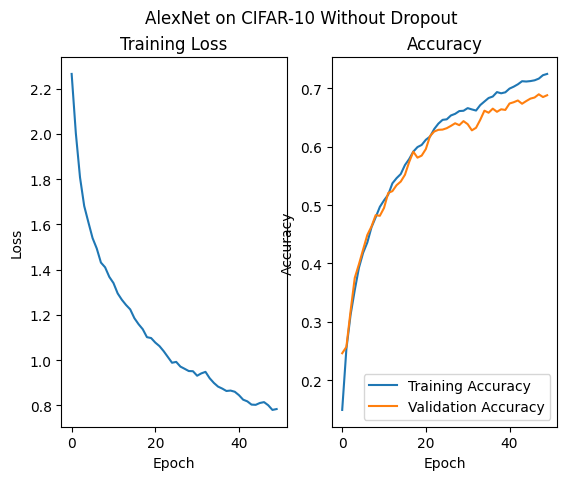

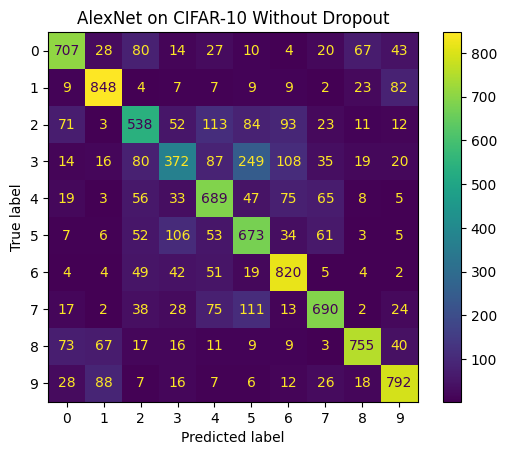

In [ ]:
alex_no_drop_10.print_results()
alex_no_drop_10.plot_training('AlexNet on CIFAR-10 Without Dropout')
alex_no_drop_10.plot_confusion_matrix('AlexNet on CIFAR-10 Without Dropout')


In [ ]:
retrain_drop = False
if retrain_drop:
   torch.cuda.empty_cache()
   alex_drop_10 = AlexNet(
      in_chan=3,
      in_dim=(32, 32),
      num_classes=10,
      block_params = [
         ConvParams(kernel=3, out_chan=16, stride=1, padding='same'),
         ConvParams(kernel=3, out_chan=32, stride=1, padding='same'),
      ],
      cnv_params = [
         ConvParams(kernel=3, out_chan=32, stride=1, padding='same'),
         ConvParams(kernel=3, out_chan=32, stride=1, padding='same'),
         ConvParams(kernel=3, out_chan=16, stride=1, padding='same'),
      ],
      fc_layers=[512, 256],
      dropout = 0.5
   ).to(device)
   
   alex_drop_10.train_model_old(
      epochs=50,
      train_loader=cifar_10_train_loader,
      val_loader=cifar_10_val_loader,
      alpha=1e-3,
      optimizer=torch.optim.Adam,
      print_epoch=1,
   )
   torch.save(alex_drop_10, 'models/alex_drop_10.pth')
else:
   alex_drop_10 = torch.load('models/alex_drop_10.pth')
   alex_drop_10.to(device)

NameError: name 'AlexNet' is not defined

Accuracy: 0.7118
Precision: 0.7333294012684151
Recall: 0.7118
F1: 0.7150286029213311
Confusion_matrix:
[[726  11  65  46  36   1   5   6  65  39]
 [ 23 777   3  18   4   3   9   2  37 124]
 [ 46   2 569 119 144  32  45  26  12   5]
 [ 17   5  45 667  84  84  29  42   8  19]
 [ 14   3  39  81 738  18  22  77   6   2]
 [  9   0  44 330  56 465  12  76   4   4]
 [  7   2  33 160  61   7 718   8   4   0]
 [ 11   1  21  64  71  40   3 776   3  10]
 [ 80  14   7  34   7   0   2   2 828  26]
 [ 31  30   6  25   3   2   3  18  28 854]]
Classification_report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1000
           1       0.92      0.78      0.84      1000
           2       0.68      0.57      0.62      1000
           3       0.43      0.67      0.52      1000
           4       0.61      0.74      0.67      1000
           5       0.71      0.47      0.56      1000
           6       0.85      0.72      0.78      1000
          

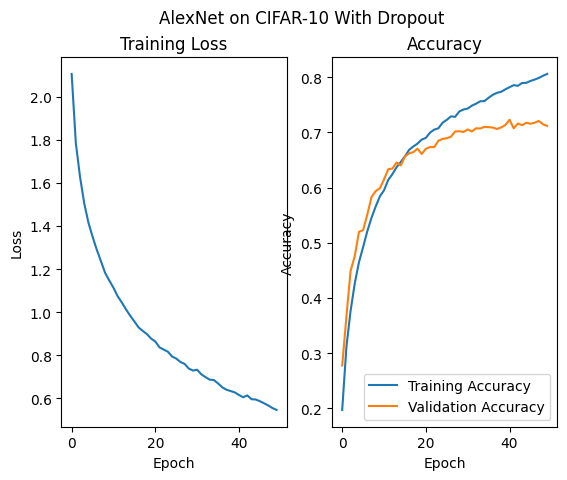

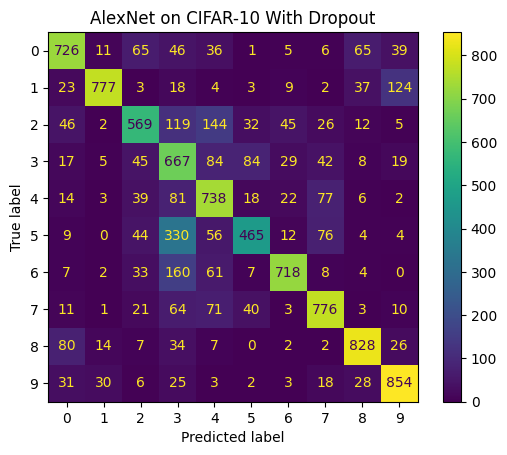

In [ ]:
alex_drop_10.print_results()
Classifier.compare_results(alex_drop_10.last_results, alex_no_drop_10.last_results)
alex_drop_10.plot_training('AlexNet on CIFAR-10 With Dropout')
alex_drop_10.plot_confusion_matrix('AlexNet on CIFAR-10 With Dropout')

NameError: name 'alex_100' is not defined

In [ ]:
def get_conv_relu(cnv_params: ConvParams):
    return nn.Sequential(
        nn.Conv2d(**cnv_params.__dict__()),
        nn.ReLU()
    )


class VggBlock(nn.Module):
    def __init__(
        self,
        params: ConvParams,
        pool_kernel = 2,
        pool_stride = 2,
        repitions = 2,
    ):
        super().__init__()
        self.computation = nn.Sequential(
            *[get_conv_relu(**params.__dict__()) for _ in range(repitions)],
            nn.MaxPool2d(pool_kernel, pool_stride),
        )
        self.pool = nn.MaxPool2d(pool_kernel, pool_stride)
    def forward(self, x):
        return self.computation(x)

class VggNet(Classifier):
    def __init__(
            self,
            in_chan,
            in_dim,
            num_classes,
            block_params: list = [],
            fc_layers = [],
        ):
        self.sequential == nn.Sequential()
        super().__init__()
        for i in range(len(block_params)):
            if i == 0:
                block_params[i][0].in_chan = in_chan
            else:
                block_params[i][0].in_chan = block_params[i-1][0].out_chan
            self.sequential.add_module(name=f'block_{i}', module=VggBlock(**block_params[i][0].__dict__(), repitions=block_params[i][1]))
        self.sequential.add_module(name='flatten', module=nn.Flatten())
        dummy_in = torch.randn(1, in_chan, *in_dim).to(device)
        dummy_out = self.sequential(dummy_in)
        fc_in = dummy_out.shape[1]
        
        for i in range(len(fc_layers)):
            layer_in = 0
            if i == 0:
                layer_in = fc_in
            else:
                layer_in = fc_layers[i-1]
            self.sequential.add_module(name=f'linear_{i}', module=nn.Sequential(
                nn.Linear(layer_in, fc_layers[i]),
                nn.ReLU(),
            ))
        self.sequential.add_module(name = 'output', module=nn.Linear(fc_layers[-1], num_classes))        
        self.sequential = self.sequential.to(device)

In [ ]:
if retrain_vgg